In [1]:
%matplotlib notebook

import random
from math import sqrt
import numpy as np
import sklearn
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import matplotlib.pyplot as plt
from numpy import concatenate
from matplotlib import pyplot as plt
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from pandas import read_csv
from datetime import datetime
from keras.layers import Bidirectional
import datetime
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from numpy import array
import time
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from keras.layers import Flatten
from keras.layers import Conv1D
#from keras.layers.convolutional import Conv1D
from keras.layers import MaxPooling1D
#from keras.layers.convolutional import MaxPooling1D
from tabulate import tabulate
from scipy.special import factorial

from plt_utils import PlotScaledData, PlotRelevance, PlotBins, PlotResampledResults
from evaluator import Evaluator


from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')


In [2]:
import torch
from torch import nn

def get_generator_block(input_dim, output_dim):      #Generator Block
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )
class GANs_Generator_FNN(nn.Module):     #Generator Model

    def __init__(self, in_dim, out_dim, hidden_dim):
        super(GANs_Generator_FNN, self).__init__()
        self.generator = nn.Sequential(
            get_generator_block(in_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim * 8, out_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.generator(noise)    
   
    def get_generator(self):
        return self.generator

def get_discriminator_block(input_dim, output_dim):       #Discriminator Block
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(0.2, inplace=True)        
    )
class GANs_Discriminator_FNN(nn.Module):         #Discriminator Model
    def __init__(self, in_dim, hidden_dim):
        super(GANs_Discriminator_FNN, self).__init__()
        self.discriminator = nn.Sequential(
            get_discriminator_block(in_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1),
        )

    def forward(self, image):
        return self.discriminator(image)
    
    def get_disc(self):
        return self.discriminator

In [3]:
def get_conv_generator_block(input_dim, output_dim, kernel_size):      #Generator Block
    print(f"input dim is {input_dim} and output dim is {output_dim}")
    return nn.Sequential(
        nn.ConvTranspose1d(input_dim, output_dim, kernel_size, 1, 0, bias=True),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True),
    )
class GANs_Generator_CNN(nn.Module):     #Generator Model

    def __init__(self, in_dim, out_dim, hid_dim):
        super(GANs_Generator_CNN, self).__init__()
        self.generator = nn.Sequential(
            # 2 1d cnn layers followed by 2 fully connected
            #get_conv_generator_block(in_dim, hid_dim * 8, 4),
            #get_conv_generator_block(hid_dim * 8, hid_dim * 4, 4),
            #get_conv_generator_block(hid_dim * 4, hid_dim * 2, 4),
            get_conv_generator_block(1, hid_dim * 8, 3),
            get_conv_generator_block(hid_dim * 8, hid_dim * 4, 3),
            #get_conv_generator_block(hid_dim * 4, hid_dim * 2, 3),
            nn.Flatten(),
            nn.LazyLinear(out_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        return self.generator(noise)    
   
    def get_generator(self):
        return self.generator

def get_conv_discriminator_block(input_dim, output_dim, kernel_size):       #Discriminator Block
    return nn.Sequential(
        nn.Conv1d(input_dim, output_dim, kernel_size, 1, 1, bias=True),
        nn.LeakyReLU(0.2, inplace=True)        
    )
class GANs_Discriminator_CNN(nn.Module):         #Discriminator Model
    def __init__(self, in_dim, hid_dim):
        super(GANs_Discriminator_CNN, self).__init__()
        self.discriminator = nn.Sequential(
            # 2 1d cnn layers followed by 2 fully connected
            get_conv_discriminator_block(1, hid_dim * 4, 3),
            get_conv_discriminator_block(hid_dim * 4, hid_dim * 8, 3),
            #get_conv_discriminator_block(hid_dim * 4, hid_dim * 2, 3),
            #get_conv_discriminator_block(hid_dim * 8, hid_dim * 4, 4),
            #get_conv_discriminator_block(hid_dim * 4, hid_dim * 2, 4),
            nn.Flatten(),
            nn.LazyLinear(1)

        )

    def forward(self, image):
        return self.discriminator(image)
    
    def get_disc(self):
        return self.discriminator

In [10]:
def get_noise(n_samples, z_dim, device='cuda'):
    return torch.randn(n_samples,z_dim,device=device) 



criterion = nn.BCEWithLogitsLoss()
n_epochs = 1#28
#sample_dim = time_step + time_ahead
sample_dim = 5
batch_size = 128
lr = 0.00001
display_step = 1
device = 'cpu'
z_dim = 128
gen = GANs_Generator_CNN(z_dim,sample_dim,128).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = GANs_Discriminator_CNN(sample_dim, 128).to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake_noise = torch.reshape(fake_noise, (num_images,1,z_dim))
    fake = gen(fake_noise)
    fake = torch.reshape(fake, (num_images,1,5))
    disc_fake_pred = disc(fake.detach())
    disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
    real = torch.reshape(real, (num_images,1,5))
    disc_real_pred = disc(real)
    disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
    disc_loss = (disc_fake_loss + disc_real_loss) / 2

    return disc_loss

def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):

    fake_noise = get_noise(num_images, z_dim, device=device)
    fake_noise = torch.reshape(fake_noise, (num_images,1,z_dim))
    fake = gen(fake_noise)
    fake = torch.reshape(fake, (num_images,1,5))
    disc_fake_pred = disc(fake)
    gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
    return gen_loss

input dim is 1 and output dim is 1024
input dim is 1024 and output dim is 512


<IPython.core.display.Javascript object>


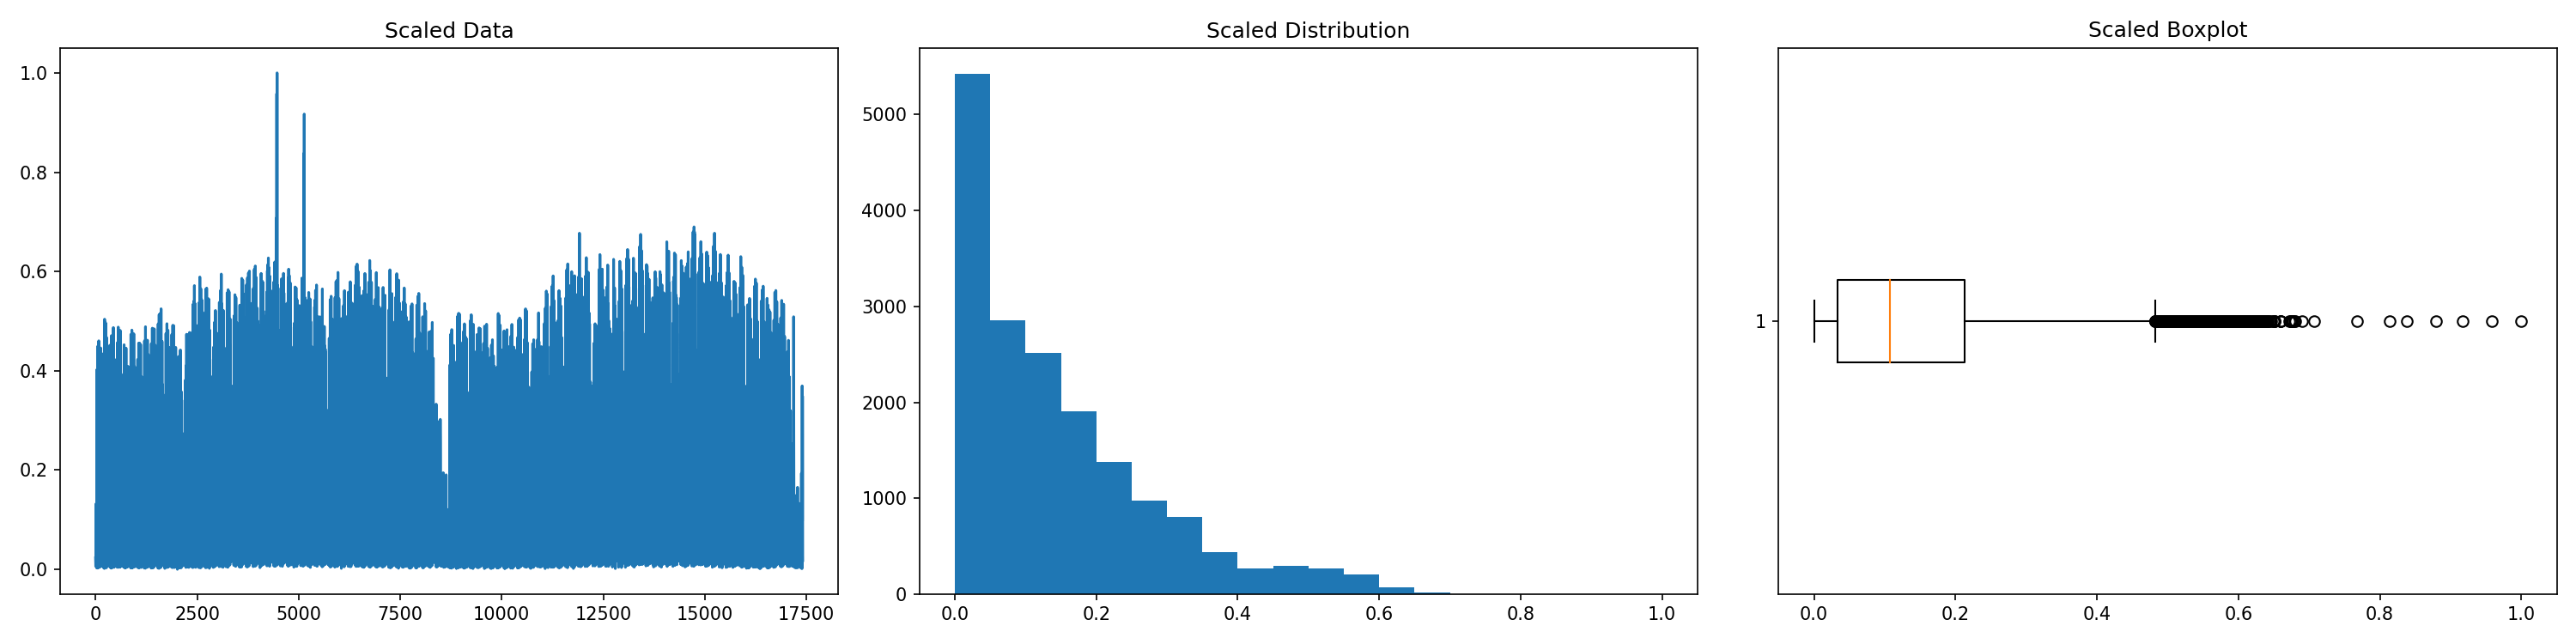

[[0.02315522]
 [0.01755725]
 [0.01704835]
 ...
 [0.36666667]
 [0.37722646]
 [0.36895674]]
11135 common values, 1050 relevant values


<IPython.core.display.Javascript object>


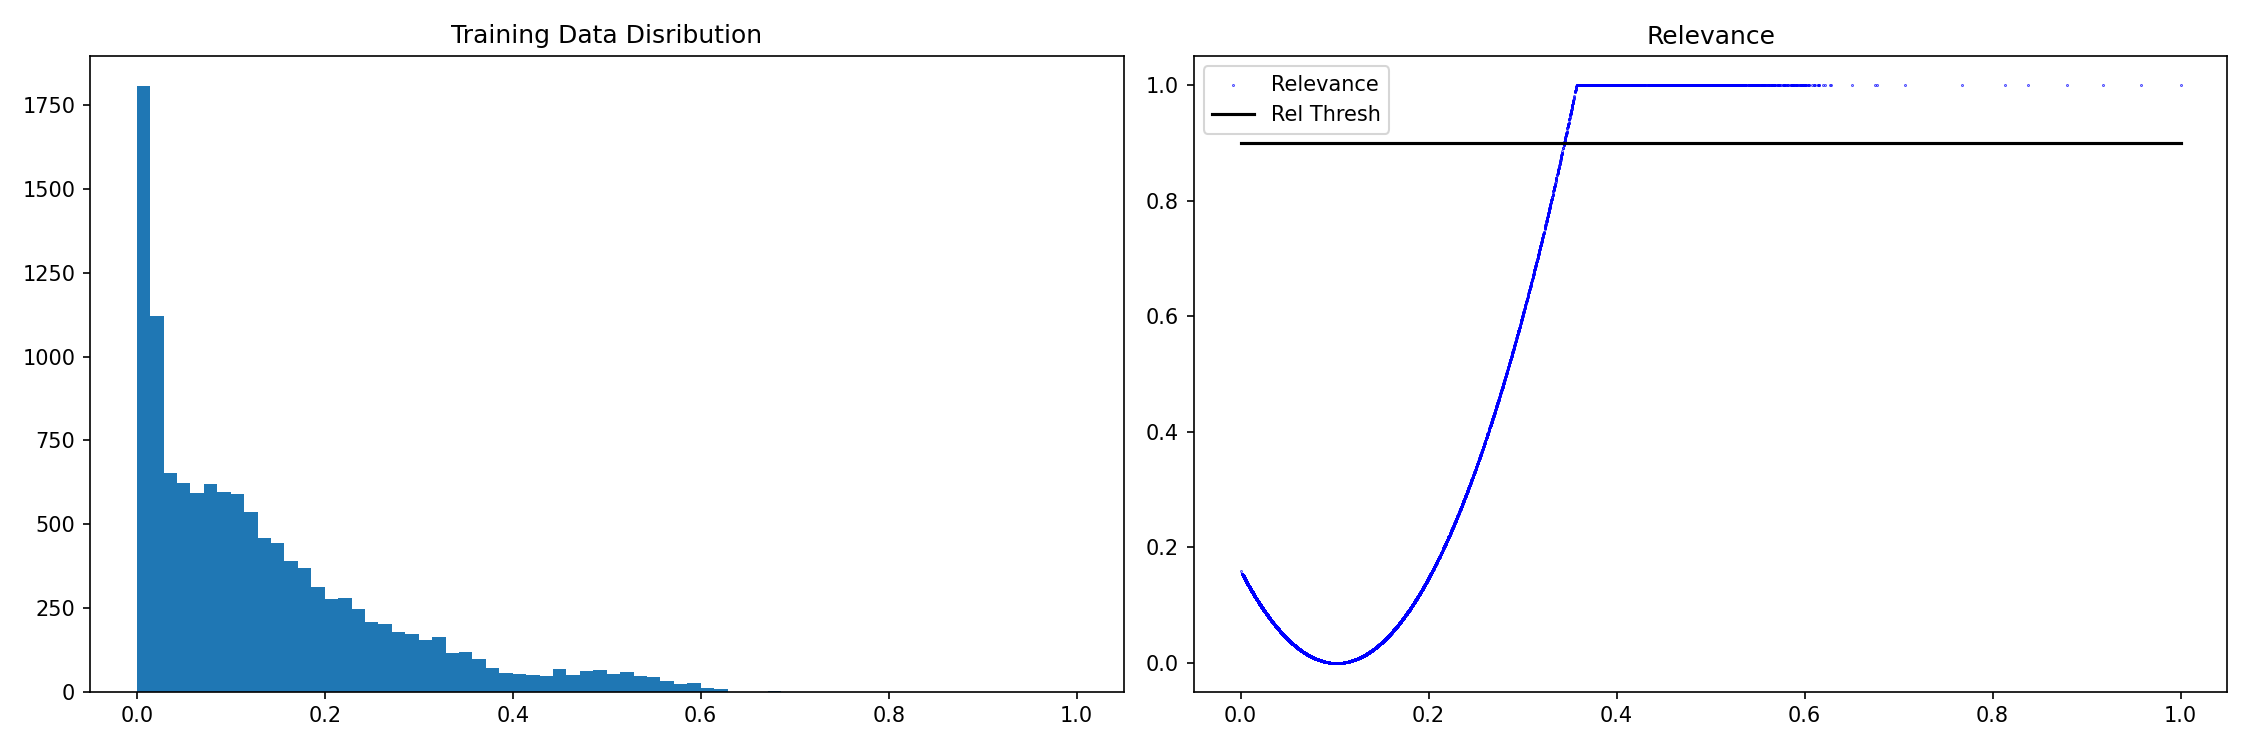

In [5]:
from scipy.interpolate import PchipInterpolator

def PCHIP_interpolator(y_train):
    q75, q25 = np.percentile(y_train, [75 ,25])
    iqr = q75 - q25
    median = np.median(y_train)
    value = [median - 1.5* iqr,median, median + 1.5 *iqr]
    #value = [median, median + 1.5 *iqr]
    relevances = [1,0,1]
    #relevances = [0,1]
    return PchipInterpolator(value, relevances, extrapolate=False)

df1=pd.read_csv("./data/london_merged.csv")
df1=df1.reset_index()['cnt']

from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1)) 
#makes target values between 0 and 1
#and puts them in numpy format [[y_t], [y_t+1], [y_t+2], ...]

PlotScaledData(df1)

# converts an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-time_step):
		a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100 
		dataX.append(a)
		dataY.append(dataset[i + time_step, 0])
	return np.array(dataX), np.array(dataY)

#dts = ["x_0","x_1","x_2","x_3","x_4","x_5","x_6"]
#dt = np.array(dts,dtype=object)
#dt = np.transpose([dt])
#dx, dy = create_dataset(dt,4)
#print(dx)
#print(dy)

time_step  = 4
SPLIT_RATIO = 0.7
def split_data(df):
    ##splitting dataset into train and test split
    training_size=int(len(df1)*SPLIT_RATIO)
    test_size=len(df1)-training_size
    train_data,test_data=df1[0:training_size,:],df1[training_size:len(df1),:]

    # reshape into X_train = [x_t, x_t+1, x_t+2, x_t+3] and y_train = [x_t+4]
    time_step = 4
    print(train_data)
    X_train, y_train = create_dataset(train_data, time_step)
    X_test, y_test = create_dataset(test_data, time_step)
    # reshape into k_x = [x_t, x_t+1, x_t+2, x_t+3, x_t+4]
    k_x = np.c_[X_train,y_train]
    return k_x, X_train, y_train, X_test, y_test

k_x, X_train, y_train, X_test, y_test = split_data(df1)

from scipy.special import factorial
import math
import numpy
import functools

#give this guy a list of training target values and it will give you a function that you can input target values to get a relevance score
def getPoisRelFunc(y):
    sample_mean = np.mean(y) 
    sample_std = np.std(y)
    rel_quant = np.quantile(1/dpois(y,sample_mean),0.5)
    return functools.partial(poisRelevance, smean=sample_mean, sstd=sample_std, rshift=rel_quant)

def PCHIPRelevance(y, pchip_func):
    rels = pchip_func.__call__(y)
    np.nan_to_num(rels, copy=False, nan=1)
    return rels

def getPCHIPRelFunc(y):
    pchip = PCHIP_interpolator(y)
    return functools.partial(PCHIPRelevance, pchip_func=pchip)

#RELEVANCE_THRESHOLD = 0.31
#RELEVANCE_FUNCTION = getPoisRelFunc(y_train)

RELEVANCE_THRESHOLD = 0.9
RELEVANCE_FUNCTION = getPCHIPRelFunc(y_train)

r_y = RELEVANCE_FUNCTION.__call__(y_train)
k_y = [val >= RELEVANCE_THRESHOLD for val in r_y]

num_rel=k_y.count(True)
print(f"{len(k_y)-num_rel} common values, {num_rel} relevant values")

r_y = np.array(r_y)
k_y = np.array(k_y)

PlotRelevance(y_train, r_y, RELEVANCE_THRESHOLD)

X_ex = X_train[k_y]
y_ex = y_train[k_y]

concat = np.c_[X_ex,y_ex]
training = np.c_[X_train,y_train]

In [8]:
print(f"k_y: {k_y.shape}")
print(f"concat: {concat.shape}")
print(f"k_X[k_Y]: {k_x[k_y].shape}")
print(f"training: {training.shape}")
print(f"k_x: {k_x.shape}")

k_y: (12185,)
concat: (1050, 5)
k_X[k_Y]: (1050, 5)
training: (12185, 5)
k_x: (12185, 5)


In [9]:
from torch.utils.data import TensorDataset, DataLoader
my_dataset = TensorDataset(torch.Tensor(concat))
print(my_dataset)
dataloader = DataLoader(
    my_dataset,
    batch_size=32,
    shuffle=True)
device = 'cpu'

cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = False 
gen_loss = False
error = False

In [12]:
from tqdm.auto import tqdm
cur_step = 0
for epoch in range(n_epochs):
  
   
    for real in tqdm(dataloader):
        real = real[0]
        cur_batch_size = len(real)

        #real = real.view(cur_batch_size, -1).to(device)
        real = real.to(device)
          
       
        disc_opt.zero_grad()
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        
        disc_loss.backward(retain_graph=True)

       
        disc_opt.step()

      
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward()
        gen_opt.step()

        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

     
        mean_discriminator_loss += disc_loss.item() / display_step

  
        mean_generator_loss += gen_loss.item() / display_step

        #print(f"curr step is {cur_step}, display step is {display_step}")
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")

            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

#10560 instead of 200???
gan_samples = []
first = False
for i in range(10):
    fake_noise = get_noise(1056, z_dim, device=device)
    fake_noise = torch.reshape(fake_noise, (1056,1,128))
    res2=gen(fake_noise)
    fres2=res2.cpu().detach().numpy()
    print(f"fres2:{fres2.shape}")
    if not first:
        first = True
        gan_samples = fres2
    else:
        gan_samples = np.append(gan_samples, fres2, axis=0)
#print(fres2.shape)
#print(fres2)
print(np.append(concat,fres2,axis=0))
GAN_resampling = {}
GAN_resampling["first"] = np.append(training,gan_samples,axis=0)




"""
fin2=np.concatenate((X_train_res[:(t2[0])], fres2), axis=0)
Xnew,ynew=shuffle_in_unison(fin2, y_train_res)
s4=0
sta4=[]
ste4=[]
sf4 =[]
for i in range(30):
    r=callf1(Xnew,ynew,X_test,y_test.ravel())
    ste4.append(r[0])
    sta4.append(r[1])
    sf4.append(r[2])  
print(X_oversampled)    
print(res2)
print(res)      
print("Mean train accuracy of NON-OVERSAMPLED=",sta,"\nMean train accuracy of SMOTE=",sta2,
      "\nMean train accuracy of GAN",sta4,"\nMean train accuracy of SMOTified-GAN",sta3)   
print("Mean test accuracy of NON-OVERSAMPLED=",ste,"\nMean test accuracy of SMOTE=",ste2,
      "\nMean test accuracy of GAN",ste4,"\nMean test accuracy of SMOTified-GAN",ste3) 
print("Mean F1 score of NON-OVERSAMPLED=",sf,"\nMean F1 score of SMOTE=",sf2,
      "\nMean F1 score of GAN",sf4,"\nMean F1 score of SMOTified-GAN",sf3) """

  6%|█████                                                                              | 2/33 [00:01<00:18,  1.64it/s]

Step 1: Generator loss: 1.4155558347702026, discriminator loss: 1.387030005455017


  9%|███████▌                                                                           | 3/33 [00:01<00:18,  1.66it/s]

Step 2: Generator loss: 0.719168484210968, discriminator loss: 0.6880170106887817


 12%|██████████                                                                         | 4/33 [00:02<00:17,  1.68it/s]

Step 3: Generator loss: 0.7257571220397949, discriminator loss: 0.6866564750671387


 15%|████████████▌                                                                      | 5/33 [00:02<00:16,  1.69it/s]

Step 4: Generator loss: 0.7307306528091431, discriminator loss: 0.678307831287384


 18%|███████████████                                                                    | 6/33 [00:03<00:15,  1.71it/s]

Step 5: Generator loss: 0.733515739440918, discriminator loss: 0.6782808899879456


 21%|█████████████████▌                                                                 | 7/33 [00:04<00:15,  1.70it/s]

Step 6: Generator loss: 0.7371008396148682, discriminator loss: 0.6775645017623901


 24%|████████████████████                                                               | 8/33 [00:04<00:14,  1.67it/s]

Step 7: Generator loss: 0.7333350777626038, discriminator loss: 0.6760390996932983


 27%|██████████████████████▋                                                            | 9/33 [00:05<00:14,  1.63it/s]

Step 8: Generator loss: 0.7263091802597046, discriminator loss: 0.6789895296096802


 30%|████████████████████████▊                                                         | 10/33 [00:06<00:13,  1.65it/s]

Step 9: Generator loss: 0.7193423509597778, discriminator loss: 0.6849865913391113


 33%|███████████████████████████▎                                                      | 11/33 [00:06<00:13,  1.62it/s]

Step 10: Generator loss: 0.7106583714485168, discriminator loss: 0.6840934753417969


 36%|█████████████████████████████▊                                                    | 12/33 [00:07<00:13,  1.56it/s]

Step 11: Generator loss: 0.6933356523513794, discriminator loss: 0.6905624866485596


 39%|████████████████████████████████▎                                                 | 13/33 [00:08<00:13,  1.49it/s]

Step 12: Generator loss: 0.6800509691238403, discriminator loss: 0.6951247453689575


 42%|██████████████████████████████████▊                                               | 14/33 [00:08<00:13,  1.40it/s]

Step 13: Generator loss: 0.6694393157958984, discriminator loss: 0.6981068849563599


 45%|█████████████████████████████████████▎                                            | 15/33 [00:09<00:13,  1.29it/s]

Step 14: Generator loss: 0.6622703671455383, discriminator loss: 0.6994073390960693


 48%|███████████████████████████████████████▊                                          | 16/33 [00:10<00:12,  1.34it/s]

Step 15: Generator loss: 0.6565145254135132, discriminator loss: 0.702984094619751


 52%|██████████████████████████████████████████▏                                       | 17/33 [00:11<00:12,  1.30it/s]

Step 16: Generator loss: 0.6534246802330017, discriminator loss: 0.7009599208831787


 55%|████████████████████████████████████████████▋                                     | 18/33 [00:12<00:12,  1.22it/s]

Step 17: Generator loss: 0.651346743106842, discriminator loss: 0.7010095119476318


 58%|███████████████████████████████████████████████▏                                  | 19/33 [00:13<00:11,  1.25it/s]

Step 18: Generator loss: 0.6502974033355713, discriminator loss: 0.6990476250648499


 61%|█████████████████████████████████████████████████▋                                | 20/33 [00:13<00:10,  1.19it/s]

Step 19: Generator loss: 0.6504505276679993, discriminator loss: 0.7014036178588867


 64%|████████████████████████████████████████████████████▏                             | 21/33 [00:14<00:10,  1.18it/s]

Step 20: Generator loss: 0.6516548991203308, discriminator loss: 0.6971144676208496


 67%|██████████████████████████████████████████████████████▋                           | 22/33 [00:15<00:08,  1.23it/s]

Step 21: Generator loss: 0.6531466841697693, discriminator loss: 0.6933116316795349


 70%|█████████████████████████████████████████████████████████▏                        | 23/33 [00:16<00:08,  1.22it/s]

Step 22: Generator loss: 0.6552371382713318, discriminator loss: 0.6916953325271606


 73%|███████████████████████████████████████████████████████████▋                      | 24/33 [00:17<00:07,  1.16it/s]

Step 23: Generator loss: 0.6573370099067688, discriminator loss: 0.6914116740226746


 76%|██████████████████████████████████████████████████████████████                    | 25/33 [00:18<00:06,  1.16it/s]

Step 24: Generator loss: 0.6599647998809814, discriminator loss: 0.6868847608566284


 79%|████████████████████████████████████████████████████████████████▌                 | 26/33 [00:19<00:05,  1.17it/s]

Step 25: Generator loss: 0.6623842120170593, discriminator loss: 0.6816211342811584


 82%|███████████████████████████████████████████████████████████████████               | 27/33 [00:19<00:05,  1.17it/s]

Step 26: Generator loss: 0.6652798056602478, discriminator loss: 0.6785824298858643


 85%|█████████████████████████████████████████████████████████████████████▌            | 28/33 [00:20<00:04,  1.18it/s]

Step 27: Generator loss: 0.6683353185653687, discriminator loss: 0.6770546436309814


 88%|████████████████████████████████████████████████████████████████████████          | 29/33 [00:21<00:03,  1.23it/s]

Step 28: Generator loss: 0.671358048915863, discriminator loss: 0.672374963760376


 91%|██████████████████████████████████████████████████████████████████████████▌       | 30/33 [00:22<00:02,  1.28it/s]

Step 29: Generator loss: 0.6742966771125793, discriminator loss: 0.6695573329925537


 94%|█████████████████████████████████████████████████████████████████████████████     | 31/33 [00:22<00:01,  1.29it/s]

Step 30: Generator loss: 0.6773390173912048, discriminator loss: 0.6684743165969849


 97%|███████████████████████████████████████████████████████████████████████████████▌  | 32/33 [00:23<00:00,  1.33it/s]

Step 31: Generator loss: 0.6805307865142822, discriminator loss: 0.6674559116363525


100%|██████████████████████████████████████████████████████████████████████████████████| 33/33 [00:24<00:00,  1.37it/s]

Step 32: Generator loss: 0.6832711100578308, discriminator loss: 0.6661698222160339


fres2:(1056, 5)
fres2:(1056, 5)
fres2:(1056, 5)
fres2:(1056, 5)
fres2:(1056, 5)
fres2:(1056, 5)
fres2:(1056, 5)
fres2:(1056, 5)
fres2:(1056, 5)
fres2:(1056, 5)
[[0.00483461 0.01030534 0.05648855 0.20318066 0.40216285]
 [0.1110687  0.08549618 0.10267176 0.15165394 0.35127226]
 [0.00508906 0.00941476 0.06743003 0.21819338 0.44961832]
 ...
 [0.04947721 0.00438089 0.00355649 0.00464691 0.00796691]
 [0.04456708 0.00229873 0.00153252 0.00349304 0.0022146 ]
 [0.07539852 0.00357968 0.00314075 0.00304832 0.00606662]]


'\nfin2=np.concatenate((X_train_res[:(t2[0])], fres2), axis=0)\nXnew,ynew=shuffle_in_unison(fin2, y_train_res)\ns4=0\nsta4=[]\nste4=[]\nsf4 =[]\nfor i in range(30):\n    r=callf1(Xnew,ynew,X_test,y_test.ravel())\n    ste4.append(r[0])\n    sta4.append(r[1])\n    sf4.append(r[2])  \nprint(X_oversampled)    \nprint(res2)\nprint(res)      \nprint("Mean train accuracy of NON-OVERSAMPLED=",sta,"\nMean train accuracy of SMOTE=",sta2,\n      "\nMean train accuracy of GAN",sta4,"\nMean train accuracy of SMOTified-GAN",sta3)   \nprint("Mean test accuracy of NON-OVERSAMPLED=",ste,"\nMean test accuracy of SMOTE=",ste2,\n      "\nMean test accuracy of GAN",ste4,"\nMean test accuracy of SMOTified-GAN",ste3) \nprint("Mean F1 score of NON-OVERSAMPLED=",sf,"\nMean F1 score of SMOTE=",sf2,\n      "\nMean F1 score of GAN",sf4,"\nMean F1 score of SMOTified-GAN",sf3) '

<IPython.core.display.Javascript object>


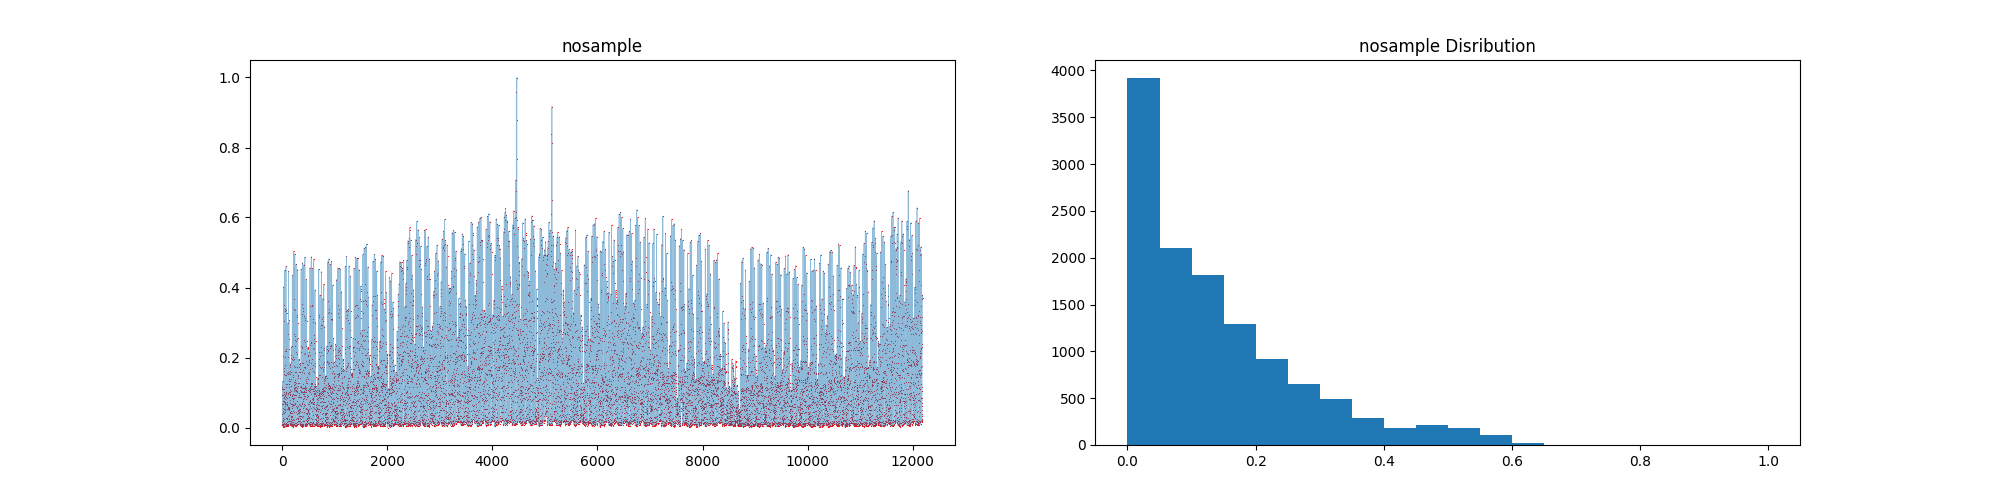

<IPython.core.display.Javascript object>


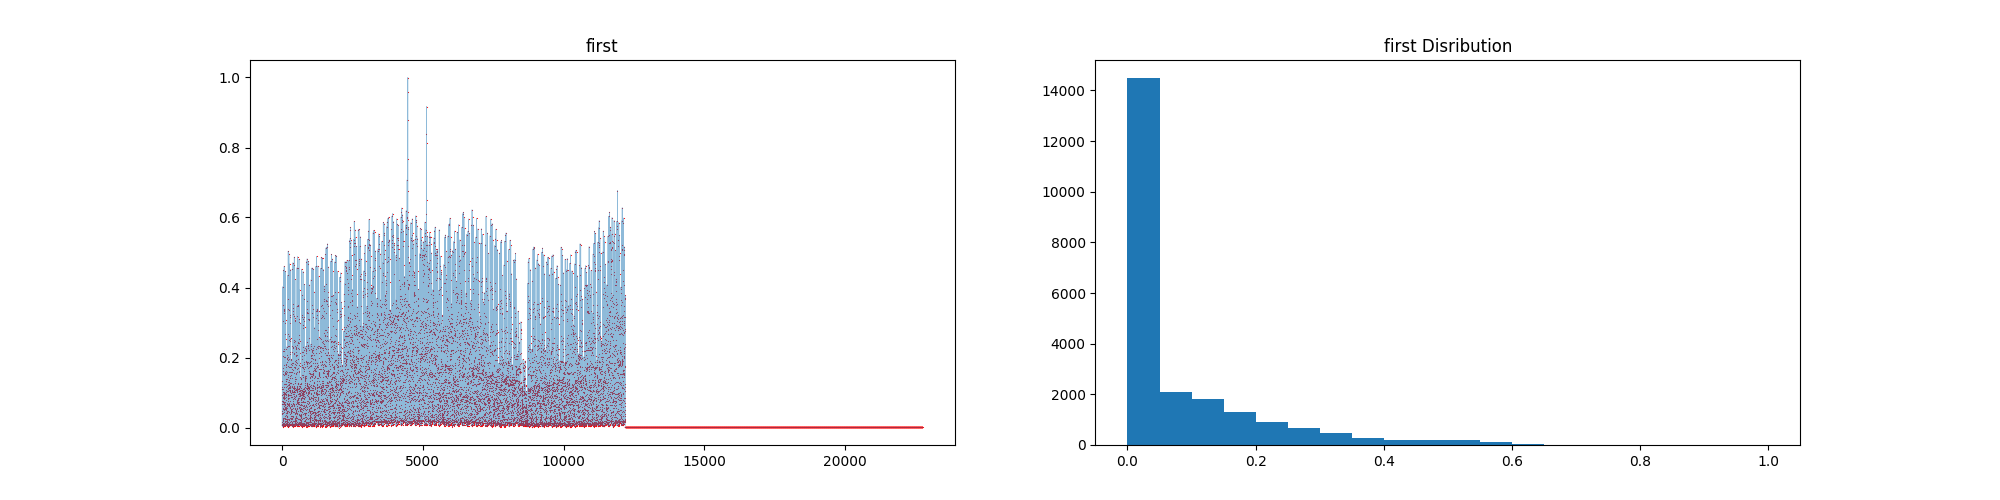

{'first': array([[2.31552163e-02, 1.75572519e-02, 1.70483461e-02, 9.16030534e-03,
         5.97964377e-03],
        [1.75572519e-02, 1.70483461e-02, 9.16030534e-03, 5.97964377e-03,
         5.85241730e-03],
        [1.70483461e-02, 9.16030534e-03, 5.97964377e-03, 5.85241730e-03,
         6.48854962e-03],
        ...,
        [6.13377802e-02, 9.99999762e-01, 1.20176228e-05, 3.04750046e-07,
         5.64777054e-07],
        [7.49632120e-02, 9.99999762e-01, 1.95326465e-05, 2.31023421e-07,
         7.46006322e-07],
        [6.35946169e-02, 9.99999881e-01, 1.34534457e-05, 1.00778941e-07,
         6.07196853e-07]])}

In [8]:
PlotResampledResults({'nosample':training},4)
PlotResampledResults(GAN_resampling, 4)
GAN_resampling

In [9]:
from sklearn.metrics import precision_score, recall_score
def precision_recall(pred, actual, relevance_thresh, relevance_function):
    # change to PCHIP
    indicator_true = relevance_function.__call__(actual)
    indicator_pred = relevance_function.__call__(pred)
    indicator_true[indicator_true <= relevance_thresh] = 0
    indicator_true[indicator_true > relevance_thresh] = 1
    indicator_pred[indicator_pred <= relevance_thresh] = 0
    indicator_pred[indicator_pred > relevance_thresh] = 1
    precision = precision_score(indicator_true, indicator_pred)
    recall = recall_score(indicator_true, indicator_pred)
    return precision, recall

def rmse(pred, actual):
    error = np.subtract(pred, actual)
    sqerror= np.sum(np.square(error))/actual.shape[0]
    return np.sqrt(sqerror)

def rmseRare(pred, actual, relevance_thresh, relevance_function):
    '''
    Computes RMSE for rare cases only (cases where autoRelevance >= relevance_threshold)
    args:
        pred: 1D numpy array of predicted target values
        actual: 1D numpy array of actual target values
        smean: sample mean of original training data
        sstd: sample standard deviation of original training data
        rquant: relevance quantile for original training data
    returns:
        Single RMSE value 
    '''
    actual_rel = relevance_function.__call__(actual)
    
    rare_ind = np.argwhere(actual_rel >= relevance_thresh)    
    
    return rmse(pred[rare_ind].flatten(), actual[rare_ind].flatten())


#####################################################
#### Utility Based Regression Evaluation Metrics ####
#####################################################


def biVariateAutoRelevance(prel, arel, m):
    '''
    Weighted averages of the individual relevances of predicted and actual target values.
    The m parameter controls how we prioritise false alarms over opportunity costs.
      False alarm: cost of predicting a relevant value for an irrelevant test case
          Setting m < 0.5 prioritises false alarms
      Opportunity cost: cost of predicting a relevant, but very different value for a relevant test case
          Setting m > 0.5 prioritises opportunity cost
      
    args: 
        prel: 1D numpy array of relevance scores for predicted target values
        arel: 1D numpy array of relevance scores for actual target values
    returns:
        1D numpy array of bivariate relevance scores
    '''
    return np.add((1-m)*prel, m*arel)

def utilityBasedLoss(prel, arel):
    '''
    Loss function used in "Utility Based Regression" (Ribeiro, 2007). 
    Not currently being used.
    It generates incosistent results so maybe I'm doing it wrong?
    '''
    all_rel = np.append(prel, arel)
    return abs(np.max(all_rel) - np.min(all_rel))

def absDeviationLoss(pred, actual):
    '''
    Absolute loss function currently being used in utilityBasedCost and utilityBasedBenefit
    '''
    return np.abs(pred - actual)

def utilityBasedCost(pred, actual, cmax, m, relevance_function):
    '''
    Computes the utility based cost associated with predictions and actual target values according to "Utility Based Regression" (Ribeiro, 2007)
    
    args:
        pred: 1D numpy array of predicted target values
        actual: 1D numpy array of actual target values
        cmax: max cost parameter
        smean: sample mean for autoRelevance
        sstd: sample standard deviation for autoRelevance
        m: m parameter for biVariateAutoRelevance
        rquant: right shift for autoRelevance function
    returns:
        single value, total utility based cost
    '''
    pred_rel = relevance_function.__call__(pred)
    actual_rel = relevance_function.__call__(actual)
    #return np.sum(cmax*biVariateAutoRelevance(pred_rel, actual_rel, m)*utilityBasedLoss(pred_rel, actual_rel))
    return np.sum(cmax*np.multiply(biVariateAutoRelevance(pred_rel, actual_rel, m),absDeviationLoss(pred_rel, actual_rel)))

def utilityBasedBenefit(pred, actual, bmax, relevance_function):
    '''
    Computes the utility based benefit associated with predictions and actual target values according to "Utility Based Regression" (Ribeiro, 2007)
    
    args:
        bmax: max reward parameter
    returns:
        single value, total utility based benefit
    '''
    pred_rel = relevance_function.__call__(pred)
    actual_rel = relevance_function.__call__(actual)
    
    #return np.sum(bmax*actual_rel*(1-utilityBasedLoss(pred_rel, actual_rel)))
    return np.sum(bmax*np.multiply(actual_rel, (1-absDeviationLoss(pred_rel, actual_rel))))



def caseWeightError(pred, actual, m, relevance_function):
    pred = np.reshape(pred,(-1,))
    pred_rel = relevance_function.__call__(pred)
    actual_rel = relevance_function.__call__(actual)
    biRel = biVariateAutoRelevance(pred_rel,actual_rel,m)
    loss = (pred-actual)**2
    caseMult = np.multiply(biRel,loss)
    return np.sum(np.multiply(biRel,loss)) / np.sum(biRel)
    

In [10]:
def MODEL_LSTM(x_train, x_test, y_train, y_test, eval_params, train_params, eval_metrics, rel_thresh, relevance_function, evaler):    
    '''
    Trains and evaluates an LSTM using data in x_train and y_train
    
    Args:
        x_train:
        x_test:
        y_train:
        y_test:
        eval_params: dictionary containing parameters for evaluating the model
        train_params: dictionary containing parameters for training the model
        eval_metrics: list of evaluation metrics that we wish to return
    Returns:
        lstm_results: evaluation results that were specified in eval_metrics
        Step_RMSE:
        Best_Predict_Test:
    '''
    m_par = eval_params['m_par']
    C_max = eval_params['C_max']
    B_max = eval_params['B_max']
    
    Num_Exp = train_params['num_exp']
    n_steps_out = train_params['n_steps_out']
    n_steps_in = train_params['n_steps_in']
    hidden = train_params['hidden']
    n_features = 1
    Epochs = train_params['epochs']
    m_par = 0.5
    C_max = 0.1
    B_max = 0.2
    
    
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features))
    print(x_train.shape)
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features))
    print(x_test.shape)
    
    #Storing eval result for each experiment
    #RMSE
    train_acc=np.zeros(Num_Exp)
    test_acc=np.zeros(Num_Exp)
    #RMSE Rare
    train_acc_rare=np.zeros(Num_Exp)
    test_acc_rare=np.zeros(Num_Exp)
    #Utility
    train_util_acc=np.zeros(Num_Exp)
    test_util_acc=np.zeros(Num_Exp)
    #UtilityBasedCost
    train_tc_acc=np.zeros(Num_Exp)
    test_tc_acc=np.zeros(Num_Exp)
    #UtilityBasedBenefit
    train_tb_acc=np.zeros(Num_Exp)
    test_tb_acc=np.zeros(Num_Exp)
    #Precision
    train_precision=np.zeros(Num_Exp)
    test_precision=np.zeros(Num_Exp)
    #Recall
    train_recall=np.zeros(Num_Exp)
    test_recall=np.zeros(Num_Exp)
    #Case Weight
    train_caseWeight=np.zeros(Num_Exp)
    test_caseWeight=np.zeros(Num_Exp)
    
    Step_RMSE=np.zeros([Num_Exp,n_steps_out])
    model = Sequential()
    model.add(LSTM(hidden, activation='relu', input_shape=(n_steps_in,n_features)))
    model.add(Dense(n_steps_out))
    model.compile(optimizer='adam', loss='mse')
    model.summary()
    Best_RMSE=1000   #Assigning a large number 
    start_time=time.time()
    for run in range(Num_Exp):
        print("Experiment",run+1,"in progress")
        # fit model
        model.fit(x_train, y_train, epochs=Epochs,batch_size=64, verbose=0, shuffle=False)
        y_predicttrain = model.predict(x_train)
        y_predicttest = model.predict(x_test)
        print(evaler)
        evaler.evaluateMetrics(run,y_predicttrain.flatten(),y_train.flatten(),y_predicttest.flatten(),y_test.flatten())
        
        train_acc[run] = rmse(y_predicttrain.flatten(),y_train.flatten()) 
        test_acc[run] = rmse(y_predicttest.flatten(), y_test.flatten()) 
        
        train_acc_rare[run] = rmseRare(y_predicttrain, y_train, rel_thresh, relevance_function) 
        test_acc_rare[run] = rmseRare(y_predicttest, y_test, rel_thresh, relevance_function) 
        
        tb_train = utilityBasedBenefit(y_predicttrain.flatten(), y_train, B_max, relevance_function)
        tb_test = utilityBasedBenefit(y_predicttest.flatten(), y_test, B_max, relevance_function)
        
        train_tb_acc[run]=tb_train
        test_tb_acc[run]=tb_test
        
        tc_train = utilityBasedCost(y_predicttrain.flatten(), y_train, C_max, m_par, relevance_function)
        tc_test = utilityBasedCost(y_predicttest.flatten(), y_test, C_max, m_par, relevance_function)
        
        train_tc_acc[run]=tc_train
        test_tc_acc[run]=tc_test
        
        train_util_acc[run] = tb_train - tc_train
        test_util_acc[run] = tb_test - tc_test
        
        train_precision[run], train_recall[run] = precision_recall(y_predicttrain, y_train, rel_thresh, relevance_function) 
        test_precision[run], test_recall[run] = precision_recall(y_predicttest, y_test, rel_thresh, relevance_function) 
        
        
        
        train_caseWeight[run] = caseWeightError(y_predicttrain, y_train, m_par, relevance_function)
        test_caseWeight[run] = caseWeightError(y_predicttest, y_test, m_par, relevance_function)
        
        if test_acc[run]<Best_RMSE:
            Best_RMSE=test_acc[run]
            Best_Predict_Test=y_predicttest
    results = {
        'Train_RMSE': train_acc,
        'Test_RMSE': test_acc,
        'Train_RMSERare': train_acc_rare,
        'Test_RMSERare': test_acc_rare,
        'Train_Benefit': train_tb_acc,
        'Test_Benefit': test_tb_acc,
        'Train_Cost': train_tc_acc,
        'Test_Cost': test_tc_acc,
        'Train_Utility': train_util_acc,
        'Test_Utility': test_util_acc,
        'Train_Precision' : train_precision,
        'Train_Recall' : train_recall,
        'Test_Precision' : test_precision,
        'Test_Recall' : test_recall,
        'Train_CaseWeight': train_caseWeight,
        'Test_CaseWeight': test_caseWeight,
    }
    
    results_official = results.copy()
    for k in results.keys():
        if k.split('_')[1] not in eval_metrics:
            del results_official[k]

    print("Total time for",Num_Exp,"experiments",time.time()-start_time)
    
    print("##############################################################")
    print("#########################EVALER###############################")
    print(evaler.results_df)
    print("##############################################################")
    
    return results_official, Step_RMSE,Best_Predict_Test    

In [11]:
def train_eval(X_train, X_test, Y_train, Y_test, desc, eval_metrics, train_params, eval_params, relevance_threshold, relevance_function, evaler):
    '''
        Trains + evaluates an LSTM model using data generated from a single resampling approach.
        Prints evaluation metrics and plots results for test data
        
        X_train: training data feature variables
        X_test: testing data feature variables
        Y_train: training data target variable
        Y_test: testing data target variable
        desc: text description of resampling approach used to generate X_train and Y_train
        eval_metrics: list of evaluation metrics we wish to compute for the LSTM
        train_params: dictionary of parameters used in MODEL_LSTM to train the model
        eval_params: dictionary of parameters used in MODEL_LSTM to evaluate the model
    '''
    x_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
    x_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)
    
    print(np.shape(x_train))
    print(np.shape(x_test))
    
    n_steps_out = 1;
    Epochs=100
    Hidden=10
    
    train_acc=np.zeros(train_params['num_exp'])
    test_acc=np.zeros(train_params['num_exp'])
    Step_RMSE=np.zeros([train_params['num_exp'],train_params['n_steps_in']])
    num_metrics = len(eval_metrics)*2
    
    print(f"############## {desc} ##############")
    lstm_results, Step_RMSE, Best_Predict_Test = MODEL_LSTM(x_train, x_test, Y_train, Y_test, eval_params, train_params, eval_metrics, relevance_threshold, relevance_function, evaler)
    #train_acc,test_acc, train_acc_rare,test_acc_rare, train_tb_acc,test_tb_acc,train_tc_acc,test_tc_acc,train_util_acc,test_util_acc,Step_RMSE,Best_Predict_Test = MODEL_LSTM(x_train, x_test, Y_train, Y_test,Num_Exp,n_steps_in,n_steps_out,Epochs,Hidden,SAMPLE_MEAN,SAMPLE_STD,RELEVANCE_THRESH, RELEVANCE_QUANT)
    arr = np.dstack(tuple(lstm_results.values()))  
    arr=arr.reshape(train_params['num_exp'],num_metrics)
    arr=np.concatenate((arr,Step_RMSE), axis=1)
    arr=arr.reshape(train_params['num_exp'],num_metrics+train_params['n_steps_out'])

    ExpIndex=np.array([])
    for j in range(train_params['num_exp']):
        ExpIndex=np.concatenate((ExpIndex,["Exp"+str(j+1)]))

    #Use keys from lstm_results
    ExpIndex1 = list(lstm_results.keys())
    #ExpIndex1=['TrainRMSE','TestRMSE','TrainRMSERare','TestRMSERare','TrainBenefit','TestBenefit','TrainCost','TestCost','TrainUtility','TestUtility']
    for j in range(train_params['n_steps_out']):
        ExpIndex1=np.concatenate((ExpIndex1,["Step"+str(j+1)]))

    arr=np.round_(arr, decimals = 5) 
    arr = pd.DataFrame(arr, index = ExpIndex , columns = ExpIndex1)
    print(arr)
    print("Means")
    print(arr.mean())
    if train_params['num_exp'] > 1:
        print("Standard Deviations")
        print(arr.std())
    x_data=np.linspace(0,Y_test.shape[0], num=Y_test.shape[0])
    plt.figure()
    plt.plot(x_data, Y_test, label='actual')
    plt.plot(x_data, Best_Predict_Test, label='predicted', alpha=0.7)  
    plt.xlabel('Time (samples)') 
    plt.title('Actual vs Predicted')
    plt.legend()
    plt.show()


def main(time_step, X_train, X_test, y_train, y_test, resampling_results, evaler, relevance_threshold, relevance_function):
    eval_metrics = ['RMSE','RMSERare','Utility','Cost','Benefit', 'Precision', 'Recall']    
    #eval_metrics = ['RMSE','RMSERare','CaseWeight']    

    ## Dictionary of parameters used for training an LSTM ##
    train_params = {
        'num_exp': 1, 
        'n_steps_in': time_step,
        'n_steps_out': 1,
        'epochs': 100,
        'hidden': 10
    }

    ## Dictionary of parameters used for computing evaluation metrics ##
    #m_par, C_max, B_max used in utility based evaluation metrics
    eval_params = {
        'm_par': 0.5, 
        'C_max': 0.1,
        'B_max': 0.2,
    }
    train_eval(X_train, X_test, y_train, y_test, "Original data", eval_metrics, train_params, eval_params, relevance_threshold, relevance_function, evaler)    
    for key in resampling_results.keys():
        res = resampling_results[key]
        x_res = res[:,:time_step]
        y_res = res[:,time_step]
        train_eval(x_res, X_test, y_res, y_test, key, eval_metrics, train_params, eval_params, relevance_threshold, relevance_function, evaler)

(12185, 4, 1)
(5221, 4, 1)
############## Original data ##############
(12185, 4, 1)
(5221, 4, 1)


2023-09-22 23:54:12.310236: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10)                480       
                                                                 
 dense (Dense)               (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress


2023-09-22 23:54:12.310839: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 23:54:12.310866: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-09-22 23:54:12.311068: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 23:54:12.313127: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been bu

164/164 [==============================] - 0s 1ms/step
Empty DataFrame
Columns: [Exp, RMSE_Train, RMSERare_Train, Utility_Train, Benefit_Train, Cost_Train, CaseWeight_Train, Precision_Train, Recall_Train, RMSE_Test, RMSERare_Test, Utility_Test, Benefit_Test, Cost_Test, CaseWeight_Test, Precision_Test, Recall_Test]
Index: []
   Exp  RMSE_Train  RMSE_Test  RMSERare_Train  RMSERare_Test  Utility_Train  \
0    0    0.042709   0.048441        0.088286       0.105094     409.792441   

   Benefit_Train  Cost_Train  Utility_Test  Benefit_Test  Cost_Test  \
0     437.345805   27.553364    214.429591    228.106255  13.676664   

   CaseWeight_Train  CaseWeight_Test  Precision_Train  Recall_Train  \
0          0.004554         0.005911         0.814855      0.720952   

   Precision_Test  Recall_Test  
0           0.864     0.723618  
Total time for 1 experiments 161.427396774292
##############################################################
#########################EVALER#######################

<IPython.core.display.Javascript object>


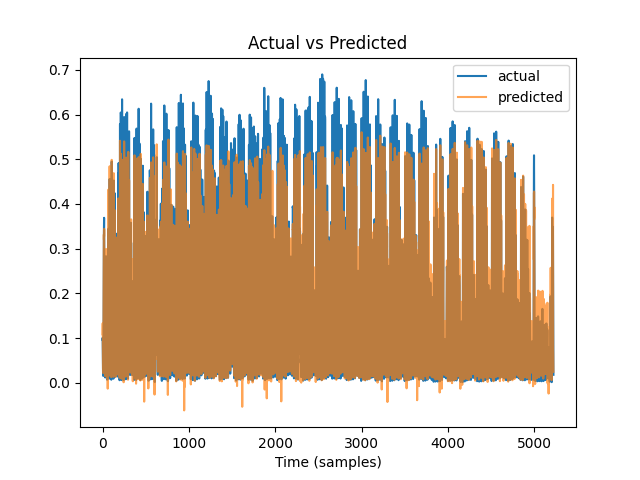

(22745, 4, 1)
(5221, 4, 1)
############## first ##############
(22745, 4, 1)
(5221, 4, 1)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 10)                480       
                                                                 
 dense_1 (Dense)             (None, 1)                 11        
                                                                 
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________
Experiment 1 in progress
164/164 [==============================] - 0s 2ms/step
  Exp  RMSE_Train  RMSERare_Train  Utility_Train  Benefit_Train  Cost_Train  \
0   0    0.042709        0.088286     409.792441     437.345805   27.553364   

   CaseWeight_Train  Precision_Train  Recall_Train  RMSE_Test  RMSERare_Test  \
0          0.004554         0.814855      0

<IPython.core.display.Javascript object>


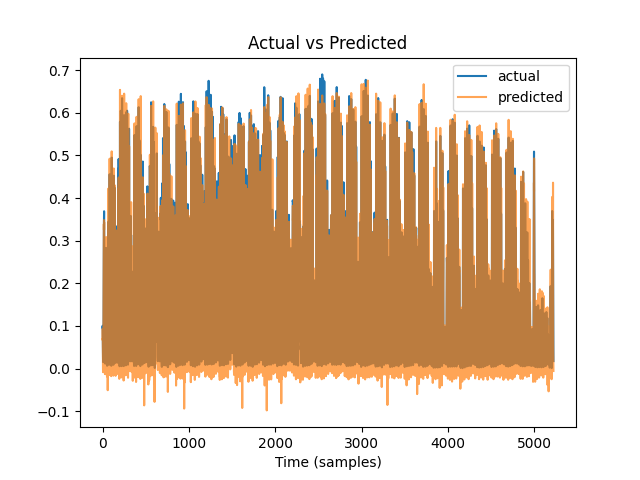

In [12]:
evaluator_params = { "RMSE": {},
                     "RMSERare": {},
                     "Utility": {'B_max':0.2, 'C_max':0.1, 'm':0.5},
                     "CaseWeight": {'m':0.5},
                     "PrecisionRecall": {}
                   }

EVALER = Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)

main(time_step, X_train, X_test, y_train, y_test, GAN_resampling, EVALER, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)

In [ ]:
evaluator_params = { "RMSE": {},
                     "RMSERare": {},
                     "Utility": {'B_max':0.2, 'C_max':0.1, 'm':0.5},
                     "CaseWeight": {'m':0.5},
                     "PrecisionRecall": {}
                   }

EVALER = Evaluator(evaluator_params, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)

main(time_step, X_train, X_test, y_train, y_test, GAN_resampling, EVALER, RELEVANCE_THRESHOLD, RELEVANCE_FUNCTION)